In [1]:
%cd ..

/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality


In [2]:
import hopsworks
import datetime
from air_pred.utils import data_preprocessing
import numpy as np
import pandas as pd
import datetime

In [3]:
project = hopsworks.login(api_key_file="api_key")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/140436
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
ms = project.get_model_serving()
my_deployment = ms.get_deployment('aqtsdeployment')

Connected. Call `.close()` to terminate connection gracefully.


In [33]:
ts_fv = fs.get_feature_view(name="air_qaulity_timeseries_fv",version = 2)
data_fg = fs.get_feature_group("cleaned_air_quality_data", version=2)

In [34]:
all_data = data_fg.read()

Finished: Reading data from Hopsworks, using ArrowFlight (1.57s) 


In [35]:
start_time = all_data.sort_values("date_time").date_time.iloc[-1]

In [36]:
predication_features = ts_fv.get_batch_data(start_time=start_time-datetime.timedelta(hours=24))

Finished: Reading data from Hopsworks, using ArrowFlight (0.62s) 


In [45]:
prev_24_hours = predication_features[(predication_features.date_time>start_time-datetime.timedelta(hours=24)) & (predication_features.date_time<=start_time)].sort_values('date_time').reset_index()
prev_24_hours_features = prev_24_hours[["prev_day", "prev_week"]].to_numpy().tolist()
predicted_prev_24_hours = np.array([my_deployment.predict(inputs=[feature])["predictions"] for feature in prev_24_hours_features])
actual_prev_24_hours = all_data[(all_data.date_time>start_time-datetime.timedelta(hours=24)) & (all_data.date_time<=start_time)].sort_values('date_time').reset_index()
predicted_prev_24_hours = predicted_prev_24_hours.squeeze()

[3.06207837 3.7606165  3.40029699 4.52294129 4.45329394 5.52203595
 6.06127051 7.03223909 5.9876374  5.23622961 4.95645628 6.43668204
 4.97428488 4.23920786 4.83867856 3.52190196 3.23766335 2.99644648
 3.0312287  3.75146685 3.04474497 2.94294845 2.38304028 2.53380385]
0    -0.657416
1    -0.771349
2    -0.724900
3     2.288130
4     2.998300
5     2.417070
6     1.792730
7     0.246067
8     1.441470
9    -1.007580
10    1.448030
11    1.514270
12    1.612050
13    0.236350
14    3.449850
15    1.200470
16    3.745240
17    3.357650
18    0.166367
19    1.249870
20    2.369700
21    0.913733
22    0.249717
23    2.526370
Name: femman_pm25, dtype: float64


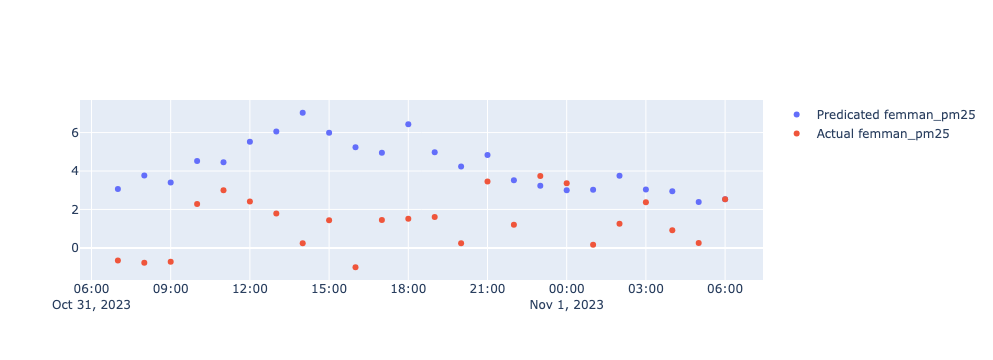

In [47]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=prev_24_hours.date_time, y=predicted_prev_24_hours,
                    mode='markers',
                    name='Predicated femman_pm25'))
fig.add_trace(go.Scatter(x=prev_24_hours.date_time, y=actual_prev_24_hours.femman_pm25,
                    mode='markers',
                    name='Actual femman_pm25'))

fig.show()

In [56]:
futur_24_hours = predication_features[(predication_features.date_time>start_time) & (predication_features.date_time<=start_time+datetime.timedelta(hours=24))].sort_values('date_time').reset_index()
futur_24_hours_features = futur_24_hours[["prev_day", "prev_week"]].to_numpy().tolist()
predictedfutur_24_hours = np.array([my_deployment.predict(inputs=[feature])["predictions"] for feature in futur_24_hours_features])
predictedfutur_24_hours = predictedfutur_24_hours.squeeze()

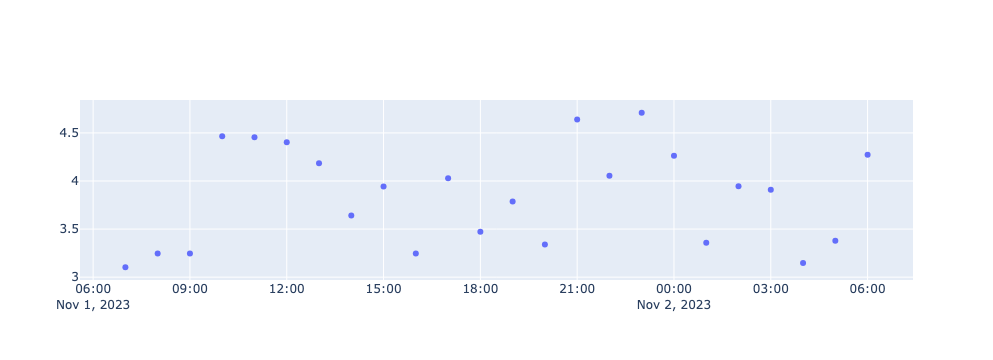

In [57]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=futur_24_hours.date_time, y=predictedfutur_24_hours,
                    mode='markers',
                    name='Predicated femman_pm25'))
fig.show()